In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter

In [2]:
device = "cpu" #"cuda" if torch.cuda.is_available() else "cpu"

In [3]:
# load les données

fichier = open('villes.txt')
donnees = fichier.read()
villes = donnees.replace('\n', ',').split(',')

In [4]:
# preparation des données

# on rajoute le token . au début et en fin
for ville, i in zip(villes, range(len(villes))):
    villes[i] = ville + '.'

# création du vocabulaire
vocabulaire = []

for ville in villes:
    for c in ville:
        if c not in vocabulaire:
            vocabulaire.append(c)

vocabulaire = sorted(vocabulaire)
vocabulaire[0] = '.'
vocabulaire[3] = " "

# pour convertir char <-> int
char_to_int = {}
int_to_char = {}

for (c, i) in zip(vocabulaire, range(len(vocabulaire))):
    char_to_int[c] = i
    int_to_char[i] = c

In [5]:
# création du dataset : a refaire

X = []
Y = []

for ville in villes:
    context = [0] * 3 # ATTENTION

    for ch in ville:
        X.append(context)
        Y.append(char_to_int[ch])

        context = context[1:] + [char_to_int[ch]]


X = torch.tensor(X) # (M, 3), int64
Y = torch.tensor(Y) # (M), int64

n1 = int(0.8*X.shape[0])

X_train = X[:n1]
X_test = X[n1:]

Y_train = Y[:n1]
Y_test= Y[n1:]

In [6]:
def get_batch(batch_size):
    ix = torch.randint(X_train.shape[0], (batch_size,))

    if device == 'cuda':
        Xb = X_train[ix].pin_memory().to(device, non_blocking=True)
        Yb = Y_train[ix].pin_memory().to(device, non_blocking=True)
    else:
        Xb = X_train[ix].to(device)
        Yb = Y_train[ix].to(device)
    
    return Xb, Yb

In [7]:
lr = 0.03
batch_size = 64
embed_dim = 16
hidden_dim = 100
context_len = 3

In [8]:
C = torch.randn((len(vocabulaire), embed_dim))

W1 = torch.randn((embed_dim*context_len, hidden_dim))
b1 = torch.zeros(hidden_dim)

W2 = torch.randn((hidden_dim, len(vocabulaire)))
b2 = torch.zeros(len(vocabulaire))

parameters = [C, W1, b1, W2, b2]

for p in parameters:
    p.requires_grad = True

In [9]:
writer = SummaryWriter(log_dir="runs/mlp/batch_size=" + str(batch_size) + "_lr=" + str(lr))

In [10]:
lri = []

for i in range(10000):
    Xb, Yb = get_batch(batch_size)

    Z1 = C[Xb].view(-1, context_len*embed_dim) @ W1 + b1
    A1 = F.tanh(Z1)

    Z2 = A1 @ W2 + b2

    loss = F.cross_entropy(Z2, Yb)

    for p in parameters:
        p.grad = None

    loss.backward()

    for p in parameters:
        p.data += -lr * p.grad

    #plt.plot(lri, lossi)

    if i%50==0:
        writer.add_scalar("train_loss", loss.item(), global_step=i)

        """
        with torch.no_grad():
            writer.add_scalars("update_to_data", {"C": (lr*C.grad.std() / C.data.std()).log10().item(),
                                                  "W1": (lr*W1.grad.std() / W1.data.std()).log10().item(), 
                                                  "W2": (lr*W2.grad.std() / W2.data.std()).log10().item(), 
                                                  "W3": (lr*W3.grad.std() / W3.data.std()).log10().item(), 
                                                  "W4": (lr*W4.grad.std() / W4.data.std()).log10().item()}, 
                                                  global_step=i)
        """
                                                  

    """
    if i%1000==0:
        writer.add_histogram("A1", A1, global_step=i)
        writer.add_histogram("A2", A2, global_step=i)
        writer.add_histogram("A3", A3, global_step=i)

        writer.add_image("A1_saturation", (torch.abs(A1) > 0.97).view(1, batch_size, -1), global_step=i)
        writer.add_image("A2_saturation", (torch.abs(A2) > 0.97).view(1, batch_size, -1), global_step=i)
        writer.add_image("A3_saturation", (torch.abs(A3) > 0.97).view(1, batch_size, -1), global_step=i)
    """

In [10]:
writer.close()

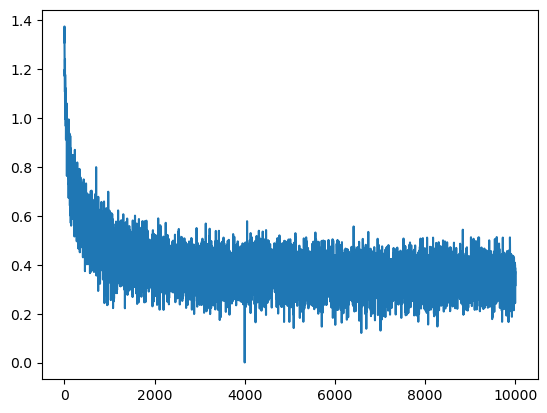

In [9]:
plt.plot(stepi, lossi)

In [25]:
Z1 = C[X_train].view(-1, context_len*16) @ W1 + b1
A1 = torch.tanh(Z1)

Z2 = A1 @ W2 + b2

loss = F.cross_entropy(Z2, Y_train)
loss

tensor(2.1199, grad_fn=<NllLossBackward0>)

In [26]:
Z1 = C[X_test].view(-1, context_len*16) @ W1 + b1
A1 = torch.tanh(Z1)

Z2 = A1 @ W2 + b2

loss = F.cross_entropy(Z2, Y_test)
loss

tensor(2.1307, grad_fn=<NllLossBackward0>)

In [28]:
# sample

g = torch.Generator().manual_seed(40 + 7)

for _ in range(10):
    nom = "..."
    while nom[-1] != "." or len(nom) == 3:
        char_moins_3 = nom[-3]
        char_moins_2 = nom[-2]
        char_moins_1 = nom[-1]

        id_moins_3 = char_to_int[char_moins_3]
        id_moins_2 = char_to_int[char_moins_2]
        id_moins_1 = char_to_int[char_moins_1]

        x = torch.asarray([id_moins_3, id_moins_2, id_moins_1]).view(-1, context_len)

        Z1 = C[x].view(-1, context_len*16) @ W1 + b1
        A1 = torch.tanh(Z1)

        Z2 = A1 @ W2 + b2
        A2 = F.softmax(Z2, dim=1)

        next_id = torch.multinomial(A2, num_samples=1, replacement=True, generator=g).item()
        next_char = int_to_char[next_id]

        nom = nom + next_char
    print(nom)

...montol.
...naiselphin-di-rouer-shén-le-blans.
...houx.
...troffes-d'ole-fe-des.
...luphe-bon-pergdebotches.
...ossies.
...le vaivones.
...saincourt-sézan.
...bois.
...soppesse-ssis.


# manip des données

In [25]:
dataset = torch.utils.data.TensorDataset(X_train, Y_train)
train_loader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True)

In [30]:
for step, (Xb, Yb) in enumerate(train_loader): #une epoch
    print(Xb.shape)

torch.Size([32, 3])
torch.Size([32, 3])
torch.Size([32, 3])
torch.Size([32, 3])
torch.Size([32, 3])
torch.Size([32, 3])
torch.Size([32, 3])
torch.Size([32, 3])
torch.Size([32, 3])
torch.Size([32, 3])
torch.Size([32, 3])
torch.Size([32, 3])
torch.Size([32, 3])
torch.Size([32, 3])
torch.Size([32, 3])
torch.Size([32, 3])
torch.Size([32, 3])
torch.Size([32, 3])
torch.Size([32, 3])
torch.Size([32, 3])
torch.Size([32, 3])
torch.Size([32, 3])
torch.Size([32, 3])
torch.Size([32, 3])
torch.Size([32, 3])
torch.Size([32, 3])
torch.Size([32, 3])
torch.Size([32, 3])
torch.Size([32, 3])
torch.Size([32, 3])
torch.Size([32, 3])
torch.Size([32, 3])
torch.Size([32, 3])
torch.Size([32, 3])
torch.Size([32, 3])
torch.Size([32, 3])
torch.Size([32, 3])
torch.Size([32, 3])
torch.Size([32, 3])
torch.Size([32, 3])
torch.Size([32, 3])
torch.Size([32, 3])
torch.Size([32, 3])
torch.Size([32, 3])
torch.Size([32, 3])
torch.Size([32, 3])
torch.Size([32, 3])
torch.Size([32, 3])
torch.Size([32, 3])
torch.Size([32, 3])


# ou

In [35]:
for i in range(20):
    Xb, Yb = next(iter(train_loader))

In [36]:
from torch.profiler import profile, record_function, ProfilerActivity